## Error Mitigation with Mitiq and PennyLane

Source: Error mitigation with Mitiq and PennyLane, https://pennylane.ai/qml/demos/tutorial_error_mitigation.html

In [4]:
import collections
import typing as t
import os

from icecream import ic

# import orquestra.sdk as sdk
# from orquestra.integrations.qiskit.runner import QiskitRunner
# from orquestra.integrations.qiskit.runner import create_ibmq_runner

import pennylane as qml
from pennylane import numpy as np

from mitiq.zne.scaling import fold_global
from mitiq.zne.scaling import fold_gates_at_random as folding
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne import execute_with_zne
from mitiq.zne.inference import AdaExpFactory

from pennylane.transforms import mitigate_with_zne
from pennylane import qchem

from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel

/var/folders/01/nndx6y3j2pg4zrjy39pt2mqw0000gn/T/ipykernel_93987/972393195.py:23: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeLima


In [5]:
# loading the default.mixed simulator and artificially adding PhaseDamping noise:
import pennylane as qml

n_wires = 4


# Describe noise
noise_gate = qml.PhaseDamping
noise_strength = 0.2

# Load devices
dev_ideal = qml.device("default.mixed", wires=n_wires)
dev_noisy = qml.transforms.insert(noise_gate, noise_strength)(dev_ideal)

In [38]:
# define a mirror circuit: let’s fix a circuit that applies a unitary 𝑈 
# followed by its inverse 𝑈†
 
from pennylane import numpy as np

np.random.seed(1967)

# Select template to use within circuit and generate parameters
n_layers = 3
template = qml.SimplifiedTwoDesign
weights_shape = template.shape(n_layers, n_wires)
w1, w2 = [2 * np.pi * np.random.random(s) for s in weights_shape]

def circuit(w1, w2):
    template(w1, w2, wires=range(n_wires))
    qml.adjoint(template)(w1, w2, wires=range(n_wires))
    return qml.expval(qml.PauliZ(0))

ideal_qnode = qml.QNode(circuit, dev_ideal)
noisy_qnode = qml.QNode(circuit, dev_noisy)

In [39]:
print(qml.draw(ideal_qnode, expansion_strategy="device")(w1, w2))

0: ──RY(4.56)─╭●──RY(5.93)──────────────╭●──RY(4.23)──────────────╭●──RY(2.59)──RY(2.59)†──────────
1: ──RY(3.60)─╰Z──RY(5.90)─╭●──RY(5.18)─╰Z──RY(2.79)─╭●──RY(5.59)─╰Z──RY(0.98)─╭●──────────RY(6.28)
2: ──RY(4.05)─╭●──RY(3.32)─╰Z──RY(1.07)─╭●──RY(3.64)─╰Z──RY(3.02)─╭●──RY(5.44)─╰Z──────────RY(6.24)
3: ──RY(3.51)─╰Z──RY(3.66)──────────────╰Z──RY(0.15)──────────────╰Z──RY(2.93)──RY(2.93)†──────────

────────────────────────────╭●───RY(4.23)†────────────────╭●───RY(5.93)†────────────────╭●─
───RY(6.28)†─╭●───RY(0.98)†─╰Z†──RY(5.59)†─╭●───RY(2.79)†─╰Z†──RY(5.18)†─╭●───RY(5.90)†─╰Z†
───RY(6.24)†─╰Z†──RY(5.44)†─╭●───RY(3.02)†─╰Z†──RY(3.64)†─╭●───RY(1.07)†─╰Z†──RY(3.32)†─╭●─
────────────────────────────╰Z†──RY(0.15)†────────────────╰Z†──RY(3.66)†────────────────╰Z†

───RY(4.56)†─┤  <Z>
───RY(3.60)†─┤     
───RY(4.05)†─┤     
───RY(3.51)†─┤     


In [40]:
ideal_qnode(w1, w2)

tensor(1., requires_grad=True)

In [41]:
noisy_qnode(w1, w2)

array(0.1754)

### Note: Convert our PennyLane circuits to OpenQASM 2.0, which is used as an intermediate representation when working with Mitiq via 'pip install pennylane-qiskit'.

In [42]:
# perform zero-noise extrapolation with Richardson extrapolation:

from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory
from pennylane.transforms import mitigate_with_zne

extrapolate = RichardsonFactory.extrapolate
scale_factors = [1, 2, 3, 4, 5]

mitigated_qnode = mitigate_with_zne(scale_factors, fold_global, extrapolate)(
    noisy_qnode
)
mitigated_qnode(w1, w2)

1.0243999999999924

In [43]:
# apply unitary folding to scale the amount of noise in the expanded circuit:
with qml.tape.QuantumTape() as circuit:
    template(w1, w2, wires=range(n_wires))
    qml.adjoint(template)(w1, w2, wires=range(n_wires))

In [44]:
scale_factors = [1, 2, 3,4,5]
folded_circuits = [fold_global(circuit, scale_factor=s) for s in scale_factors]

for s, c in zip(scale_factors, folded_circuits):
    print(f"Globally-folded circuit with a scale factor of {s}:")
    print(qml.drawer.tape_text(c, decimals=2, max_length=80))
    print()

Globally-folded circuit with a scale factor of 1:
0: ──RY(4.56)─╭●──RY(5.93)──────────────╭●──RY(4.23)──────────────╭●──RY(2.59)
1: ──RY(3.60)─╰Z──RY(5.90)─╭●──RY(5.18)─╰Z──RY(2.79)─╭●──RY(5.59)─╰Z──RY(0.98)
2: ──RY(4.05)─╭●──RY(3.32)─╰Z──RY(1.07)─╭●──RY(3.64)─╰Z──RY(3.02)─╭●──RY(5.44)
3: ──RY(3.51)─╰Z──RY(3.66)──────────────╰Z──RY(0.15)──────────────╰Z──RY(2.93)

───RY(-2.59)────────────────────────────────────╭●──RY(-4.23)───────────────╭●
──╭●──────────RY(6.28)──RY(-6.28)─╭●──RY(-0.98)─╰Z──RY(-5.59)─╭●──RY(-2.79)─╰Z
──╰Z──────────RY(6.24)──RY(-6.24)─╰Z──RY(-5.44)─╭●──RY(-3.02)─╰Z──RY(-3.64)─╭●
───RY(-2.93)────────────────────────────────────╰Z──RY(-0.15)───────────────╰Z

───RY(-5.93)───────────────╭●──RY(-4.56)─┤  
───RY(-5.18)─╭●──RY(-5.90)─╰Z──RY(-3.60)─┤  
───RY(-1.07)─╰Z──RY(-3.32)─╭●──RY(-4.05)─┤  
───RY(-3.66)───────────────╰Z──RY(-3.51)─┤  

Globally-folded circuit with a scale factor of 2:
0: ──RY(4.56)─╭●──RY(5.93)──────────────╭●──RY(4.23)──────────────╭●──RY(2.59)
1: ──R

In [45]:
# define an executor function that adds the PauliZ measurement onto the first qubit 
# of each input circuit and then runs the circuits on a target device:
def executor(circuits, dev=dev_noisy):
    # Support both a single circuit and multiple circuit execution
    circuits = [circuits] if isinstance(circuits, qml.tape.QuantumTape) else circuits

    circuits_with_meas = []

    # Loop through circuits and add on measurement
    for c in circuits:
        with qml.tape.QuantumTape() as circuit_with_meas:
            for o in c.operations:
                qml.apply(o)
            qml.expval(qml.PauliZ(0))
        circuits_with_meas.append(circuit_with_meas)

    return qml.execute(circuits_with_meas, dev, gradient_fn=None)

In [47]:
executor(folded_circuits, dev=dev_ideal) 

[array(1.), array(1.), array(1.), array(1.), array(1.)]

In [30]:
# First run: [tensor(0.71729164, requires_grad=True),
# tensor(0.54368629, requires_grad=True),
# tensor(0.3777036, requires_grad=True)]

#Second run (noise factor 0.2, scale factor [1,2,3,4,5] ): 
# [tensor(0.5007169, requires_grad=True),
#  tensor(0.287184, requires_grad=True),
#  tensor(0.1371938, requires_grad=True),
#  tensor(0.0832677, requires_grad=True),
#  tensor(0.04401553, requires_grad=True)]

#Third run for n_layer = 2:
# tensor(1., requires_grad=True),
# tensor(1., requires_grad=True),
# tensor(1., requires_grad=True),
# tensor(1., requires_grad=True)]

#Forth run n_layer = 3:
#[array(1.), array(1.), array(1.), array(1.), array(1.)] : I am quite confused why I am getting array instead of tensor this time.



In [48]:
# perform Richardson extrapolation to determine zero-noise limit 
# of expectation value of interest:

# Evaluate noise-scaled expectation values
noisy_expectation_values = executor(folded_circuits, dev=dev_noisy)

# Initialize extrapolation method
fac = RichardsonFactory(scale_factors)

# Load data into extrapolation factory
for x, y in zip(scale_factors, noisy_expectation_values):
    fac.push({"scale_factor": x}, y)

# Run extrapolation
zero_noise = fac.reduce()

print(f"ZNE result: {zero_noise[0]}")

IndexError: invalid index to scalar variable.

In [ ]:
#I could not figure out why I am getting invalid index.

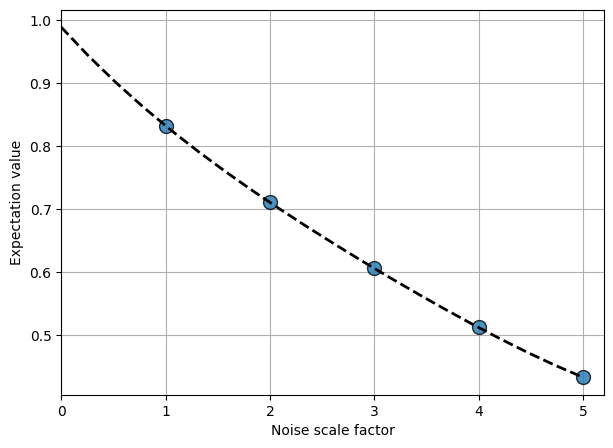

In [55]:
_ = fac.plot_fit()

In [56]:
# add zero-point extrapolation to exp. value measurement via decorator:
from mitiq.zne.scaling import fold_gates_at_random as folding

extrapolate = RichardsonFactory.extrapolate

@mitigate_with_zne(scale_factors, folding, extrapolate, reps_per_factor=100)
@qml.qnode(dev_noisy)
def mitigated_qnode(w1, w2):
    template(w1, w2, wires=range(n_wires))
    qml.adjoint(template)(w1, w2, wires=range(n_wires))
    return qml.expval(qml.PauliZ(0))

mitigated_qnode(w1, w2)

0.9598499999999969

In [ ]:
#for n_layer = 2, I got more bent exponential curve whereas for n_layer = 3, I got a less bent exponential curve.

In [57]:
# stochastic folding function with randomly-selected gates using a scale factor == 1.1:
for _ in range(3):
    print(qml.drawer.tape_text(folding(circuit, scale_factor=1.1), decimals=2, max_length=80))

0: ──RY(4.56)─╭●──RY(5.93)──────────────╭●──RY(4.23)──────────────╭●──RY(2.59)
1: ──RY(3.60)─╰Z──RY(5.90)─╭●──RY(5.18)─╰Z──RY(2.79)─╭●──RY(5.59)─╰Z──RY(0.98)
2: ──RY(4.05)─╭●──RY(3.32)─╰Z──RY(1.07)─╭●──RY(3.64)─╰Z──RY(3.02)─╭●──RY(5.44)
3: ──RY(3.51)─╰Z──RY(3.66)──────────────╰Z──RY(0.15)──────────────╰Z──RY(2.93)

───RY(-2.59)───────────────────────────────────────────────────────────────╭●
──╭●──────────RY(6.28)──RY(-6.28)──────────────────────╭●─╭●─╭●──RY(-0.98)─╰Z
──╰Z──────────RY(6.24)──RY(-6.24)──RY(6.24)──RY(-6.24)─╰Z─╰Z─╰Z──RY(-5.44)─╭●
───RY(-2.93)───────────────────────────────────────────────────────────────╰Z

───RY(-4.23)───────────────╭●──RY(-5.93)───────────────╭●──RY(-4.56)──RY(4.56)
───RY(-5.59)─╭●──RY(-2.79)─╰Z──RY(-5.18)─╭●──RY(-5.90)─╰Z──RY(-3.60)──────────
───RY(-3.02)─╰Z──RY(-3.64)─╭●──RY(-1.07)─╰Z──RY(-3.32)─╭●──RY(-4.05)──────────
───RY(-0.15)───────────────╰Z──RY(-3.66)───────────────╰Z──RY(-3.51)──────────

───RY(-4.56)─┤  
─────────────┤  
─────────────┤  
──

In [59]:
# adaptive approach to zne extrapolation using a sequence of scale factors with AdaExpFactory:
from mitiq.zne import execute_with_zne
from mitiq.zne.inference import AdaExpFactory

factory = AdaExpFactory(steps=20)

execute_with_zne(circuit, executor, factory=factory, scale_noise=fold_global)

1.0078648215460977

#### Mitigating noisy circuits in quantum chemistry

Calculating the potential energy surface of molecular hydrogen. 

In [60]:
# upload 'fake' noise data for ibmq_lima device
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel

backend = FakeLima()
noise_model = NoiseModel.from_backend(backend)

/var/folders/01/nndx6y3j2pg4zrjy39pt2mqw0000gn/T/ipykernel_93987/2292160280.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeLima


In [61]:
n_wires = 4

dev_ideal = qml.device("default.qubit", wires=n_wires)
dev_noisy = qml.device(
    "qiskit.aer",
    wires=n_wires,
    noise_model=noise_model,
    optimization_level=0,
    shots=10000,
)

In [64]:
# import sys
# sys.path.append("/home/orquestra/qc_seminar_4/")
# params = np.load("/home/orquestra/qc_seminar_4/params.npy")
params = np.array([1.28818974, 0.63447815, 0.15141406, 0.19522786, 0.24828548,
       0.31181026, 0.38728731, 0.47580621, 0.57683907, 0.68730219])

In [63]:
# Describe quantum chemistry problem

# ground-state energy of hydrogen molecule:
from pennylane import qchem

symbols = ["H", "H"]
distances = np.arange(0.5, 3.0, 0.25)

ideal_energies = []
noisy_energies = []

for r, phi in zip(distances, params):
    # Assume atoms lie on the Z axis
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Load qubit Hamiltonian
    H, _ = qchem.molecular_hamiltonian(symbols, coordinates)

    # Define ansatz circuit
    def qchem_circuit(phi):
        qml.PauliX(wires=0)
        qml.PauliX(wires=1)
        qml.DoubleExcitation(phi, wires=range(n_wires))
        return qml.expval(H)

    ideal_energy = qml.QNode(qchem_circuit, dev_ideal)
    noisy_energy = qml.QNode(qchem_circuit, dev_noisy)

    ideal_energies.append(ideal_energy(phi))
    noisy_energies.append(noisy_energy(phi))

In [ ]:
# error-mitigated version of the potential energy surface:

mitig_energies = []

for r, phi in zip(distances, params):
    # Assume atoms lie on the Z axis
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r])

    # Load qubit Hamiltonian
    H, _ = qchem.molecular_hamiltonian(symbols, coordinates)

    # Define ansatz circuit
    with qml.tape.QuantumTape() as circuit:
        qml.PauliX(wires=0)
        qml.PauliX(wires=1)
        qml.DoubleExcitation(phi, wires=range(n_wires))

    # Define custom executor that expands Hamiltonian measurement
    # into a linear combination of tensor products of Pauli
    # operators.
    def executor(circuit):

        # Add Hamiltonian measurement to circuit
        with qml.tape.QuantumTape() as circuit_with_meas:
            for o in circuit.operations:
                qml.apply(o)
            qml.expval(H)

        # Expand Hamiltonian measurement into tensor product of
        # of Pauli operators. We get a list of circuits to execute
        # and a postprocessing function to combine the results into
        # a single number.
        circuits, postproc = qml.transforms.hamiltonian_expand(
            circuit_with_meas, group=False
        )
        circuits_executed = qml.execute(circuits, dev_noisy, gradient_fn=None)
        return postproc(circuits_executed)

    mitig_energy = execute_with_zne(circuit, executor, scale_noise=fold_global)
    mitig_energies.append(mitig_energy)

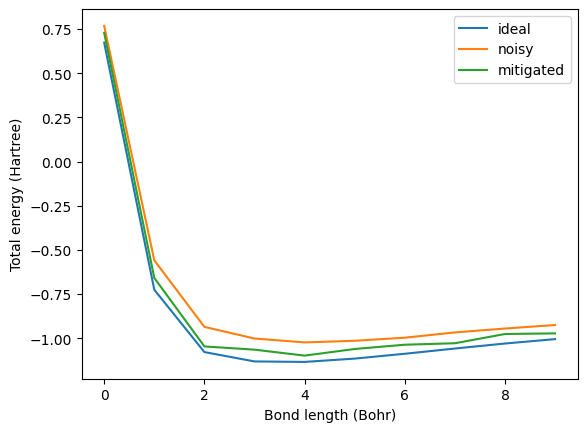

In [24]:
import matplotlib.pyplot as plt

plt.plot(ideal_energies, label="ideal")
plt.plot(noisy_energies, label="noisy")
plt.plot(mitig_energies, label="mitigated")
plt.xlabel("Bond length (Bohr)")
plt.ylabel("Total energy (Hartree)")
plt.legend()
plt.show()